# Time Series Forcasting Model based on LSTM with 'sunspots' dataset - Clone Project([Time Series-Tensorflow RNN-LSTM Introduction](https://www.kaggle.com/kutaykutlu/time-series-tensorflow-rnn-lstm-introduction))

## Step 0. Libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf 
print(tf.__version__)

import warnings
warnings.filterwarnings('ignore')

/Users/swsong/opt/anaconda3/envs/dataScience/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
2.2.0


## Step 1. The Functions
- Let's built some useful function to use in the next steps 

In [2]:
# It is a simple function to plot time x axis values y axis

def plot_series(time, series, format='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)

In [3]:
# Inputs: data series, size of the window, The size of the batches to use when training, The size of the shuffle buffer, which determines how the data will be shuffled.
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # Expand the dimensions of the series to work with the LSTM's
    series = tf.expand_dims(series, axis=-1)
    # Create dataset ds from the series
    ds = tf.data.Dataset.from_tensor_slices(series)
    # Slice the data up into the appropriate windows, shifted by one time set.
    # Keep them all the same size by setting drop remainder to true.
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    # Flatten the data into chunks in the size of our window_size+1
    ds = ds.flat_map(lambda w : w.batch(window_size+1))
    # Shuffle it with shuffle buffer that speeds things up with large datasets
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w : (w[:-1], w[1:]))
    # Return the dataset that batched into the selected batch size
    return ds.batch(batch_size).prefetch(1)
    

In [31]:
# We can use this function to make some prediction by using the trained mode 1
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## Step 2. Data Exploration and Preparation

This data tracks sunspots on a monthly basis from 1749 until 2019.

Sunspots do have seasonal cycles approximately every 11 years.

In [6]:
df_sun = pd.read_csv('./data/sunspots.csv')

In [7]:
print(df_sun.shape)

(3235, 3)


In [8]:
df_sun.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [11]:
for col in df_sun.columns:
    print(col)

Unnamed: 0
Date
Monthly Mean Total Sunspot Number


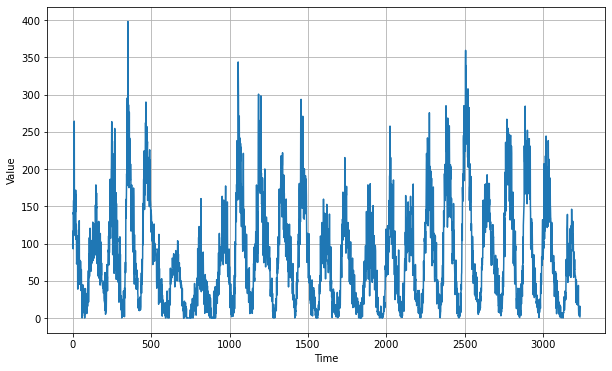

In [13]:
# Let's visualizer the data
series = df_sun['Monthly Mean Total Sunspot Number']
time = df_sun['Unnamed: 0']

plt.figure(figsize=(10,6))
plot_series(time, series)

## Step 3. Split Train-Test Dataset

In [14]:
# Let's take 80% of the data as train set
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Step 4. Model

In [15]:
# Let's define random_seeds and the variables
# Clear keras session
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

shuffle_buffer_size = 1000
window_size = 64
batch_size = 128

# Use windowed_dataset function to make dataset suitable(for model)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


In [18]:
# We use 'lr_schedule' to see which 'learning rate' is optimum
# Run the model with less epoch to visualize 'learning rate' vs 'loss'
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-8 * 10**(epoch/20)
)
# Optimizer and loss parameters
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
loss = tf.keras.losses.Huber()

In [19]:
# Build and Fit the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(
        filters=64, kernel_size=5,
        strides=1, padding='causal',
        activation='relu',
        input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x : x * 400)
])

In [20]:

model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
20/20 [==============================] - 2s 103ms/step - loss: 78.0704 - mae: 78.5674 - lr: 1.0000e-08
Epoch 2/100
20/20 [==============================] - 2s 107ms/step - loss: 60.3234 - mae: 60.8203 - lr: 1.1220e-08
Epoch 3/100
20/20 [==============================] - 2s 107ms/step - loss: 46.2554 - mae: 46.7518 - lr: 1.2589e-08
Epoch 4/100
20/20 [==============================] - 2s 110ms/step - loss: 43.5240 - mae: 44.0208 - lr: 1.4125e-08
Epoch 5/100
20/20 [==============================] - 2s 106ms/step - loss: 42.3511 - mae: 42.8480 - lr: 1.5849e-08
Epoch 6/100
20/20 [==============================] - 2s 107ms/step - loss: 41.4809 - mae: 41.9779 - lr: 1.7783e-08
Epoch 7/100
20/20 [==============================] - 2s 112ms/step - loss: 40.6760 - mae: 41.1729 - lr: 1.9953e-08
Epoch 8/100
20/20 [==============================] - 2s 107ms/step - loss: 39.8433 - mae: 40.3399 - lr: 2.2387e-08
Epoch 9/100
20/20 [==============================] - 2s 108ms/step - loss: 38.99

(1e-08, 0.001, 0.0, 80.0)

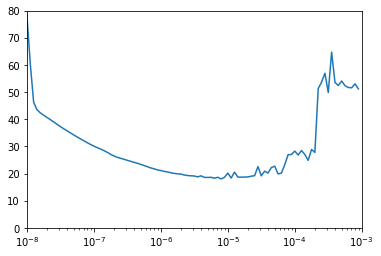

In [22]:
# Let's visualize 'learning rate' vs 'loss'
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 80])

This suggests the best learning rate for this network will be around '7e-5'

In [23]:
# Let's rerun the model with the optimul learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

shuffle_buffer_size = 1000
window_size = 64
batch_size = 64

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

optimizer = tf.keras.optimizers.SGD(lr=7e-6, momentum=0.9)
loss = tf.keras.losses.Huber()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                          strides=1, padding='causal',
                          activation='relu',
                          input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])


model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

history = model.fit(train_set, epochs=200)

Epoch 1/200
39/39 [==============================] - 2s 49ms/step - loss: 44.5439 - mae: 45.0406
Epoch 2/200
39/39 [==============================] - 2s 44ms/step - loss: 23.5864 - mae: 24.0805
Epoch 3/200
39/39 [==============================] - 2s 45ms/step - loss: 20.9196 - mae: 21.4129
Epoch 4/200
39/39 [==============================] - 2s 44ms/step - loss: 19.9841 - mae: 20.4771
Epoch 5/200
39/39 [==============================] - 2s 45ms/step - loss: 19.2699 - mae: 19.7626
Epoch 6/200
39/39 [==============================] - 2s 46ms/step - loss: 19.5131 - mae: 20.0061
Epoch 7/200
39/39 [==============================] - 2s 44ms/step - loss: 18.9204 - mae: 19.4130
Epoch 8/200
39/39 [==============================] - 2s 45ms/step - loss: 18.4834 - mae: 18.9759
Epoch 9/200
39/39 [==============================] - 2s 45ms/step - loss: 18.1904 - mae: 18.6825
Epoch 10/200
39/39 [==============================] - 2s 45ms/step - loss: 18.0460 - mae: 18.5381
Epoch 11/200
39/39 [=========

First 10 Predictions : 
 [245.74234 233.78325 266.14096 248.23775 216.10547 269.7908  266.33826
 231.67482 253.56297 238.95375]

mae :  18.23292


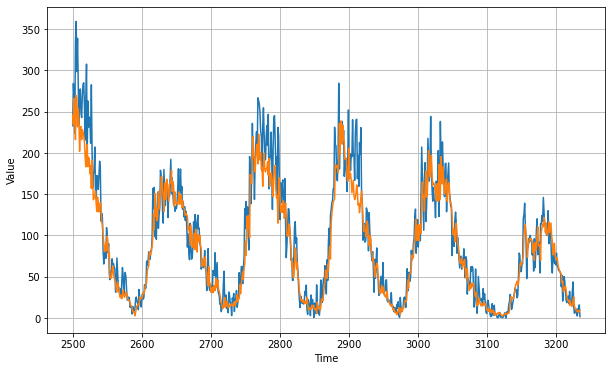

In [37]:
rnn_forecast = model_forecast(model, series[:, np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
print("First 10 Predictions :","\n", rnn_forecast[:10])
print('')
print("mae : ", tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Question. (numpy ellipsis error)

In [40]:
series[..., np.newaxis]

KeyError: (Ellipsis, None)

In [42]:
series[:, np.newaxis]

array([[ 96.7],
       [104.3],
       [116.7],
       ...,
       [ 13.2],
       [ 15.9],
       [  1.6]])